In [10]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import cv2
from numpy.fft import fft2, ifft2

In [11]:
from math import pi, exp

def gaussian_pdf_2D(x, y, sigma=1):
    exp_term = -(x*x + y*y) / (2.*sigma*sigma)
    const_term = 1/(2*pi*(sigma**2))
    return const_term * exp(exp_term)

def get_gaussian_filter(kernel_size=(3,3), sigma=1):
    if type(kernel_size) == type(1):
        m = n = kernel_size
    else:
        m, n = kernel_size
    if (m%2 != 1) or (n%2 != 1):
        raise Exception("Kernel size must be odd ", kernel_size)
    gaussian_kernel = np.zeros((m,n))
    center_x = (n+1) // 2 -1
    center_y = (m+1) // 2 -1
    for u in range(n):
        for v in range(m):
            gaussian_kernel[v, u] = gaussian_pdf_2D(u-center_x, v-center_y, sigma)
    gaussian_kernel /= gaussian_kernel.sum()
    return gaussian_kernel

In [12]:
def zero_padding(img, size=(1,1)):
    if type(size) == type(1):
        oy = ox = size
    else:
        oy, ox = size
    m, n = img.shape
    img_pad = np.zeros((m+2*oy, n+2*ox))
    img_pad[oy:-oy, ox:-ox] = img
    return img_pad
    
def convolution_2D(img, filter, padding=True):
    if len(img.shape) != 2:
        raise Exception("Only support gray image right now !", img.shape)
    m, n = img.shape
    p, q = filter.shape
    
    ox = (q-1)//2
    oy = (p-1)//2
    if padding:
        img = zero_padding(img, size=(oy,ox))
        m, n = img.shape
    
    output_img = np.zeros((m, n))
    for cy in range(oy, m-oy):
        for cx in range(ox, n-ox):
            img_window = img[(cy-oy):(cy+oy)+1:, (cx-ox):(cx+ox)+1]
            output_img[cy, cx] = np.sum(img_window*filter)
            
    output_img = output_img[oy:-oy, ox:-ox]
    return output_img

In [68]:
def subsampling(img, size=(64,64)):
    if len(img.shape) != 2:
        raise Exception("Only support gray image right now !", img.shape)
    m, n = img.shape
    sy = m/size[0]
    sx = n/size[1]
    img_sub = np.zeros(size)
    for row in range(size[0]):
        for col in range(size[1]):
            r = min(row*sy, m-1)
            c = min(col*sx, n-1)
            img_sub[row][col] = img[int(r)][int(c)]
    return img_sub

# def bilinear_interpolation(img, size=(128,128)):
#     pass

def nearest_interpolation(img, size=(128,128)):
    m, n = img.shape
    img_up = np.zeros(size)
    sy = size[0]/m
    sx = size[1]/n
    for y in range(m):
        for x in range(n):
            y_low = int(y*sy)
            y_high = int((y+1)*sy)
            x_low = int(x*sx)
            x_high = int((x+1)*sx)
            img_up[y_low:y_high, x_low:x_high] = img[y,x] 
    return img_up

In [69]:
def image_pyramid(img, gaussian_filter, pyramid_size):
    gaussian_pyramid = {}  # Gaussian Pyramid
    laplacian_pyramid = {} # Laplacian Pyramid (Laplacian of Gaussian)
    gaussian_pyramid[pyramid_size[0]] = cv2.resize(img, (pyramid_size[0], pyramid_size[0]))
    
    for s in pyramid_size[1:]:
        size =(s, s)
        img = gaussian_pyramid[s*2]
        
        # compute gaussian
        img_smooth = convolution_2D(img, gaussian_filter)
        img_sub = subsampling(img_smooth, size)
        gaussian_pyramid[s] = img_sub
        
        # compute laplacian
        img_up = nearest_interpolation(img_sub, (s*2, s*2))
        img_laplacian = img - img_up
        laplacian_pyramid[s*2] = img_laplacian
    return gaussian_pyramid, laplacian_pyramid

In [70]:
def fft(channel):
    fft = np.fft.fft2(channel)
    fft /= fft.max()  
    return np.absolute(fft) - 0.5

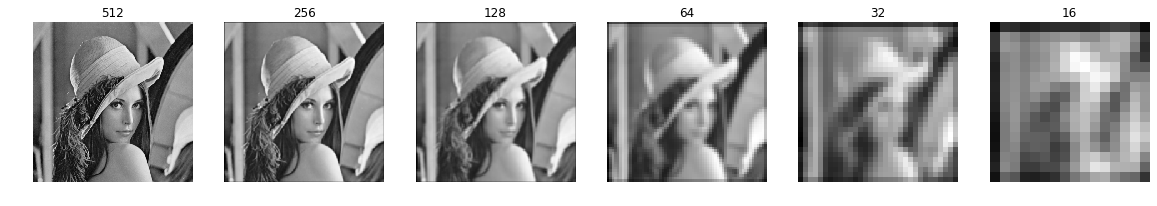

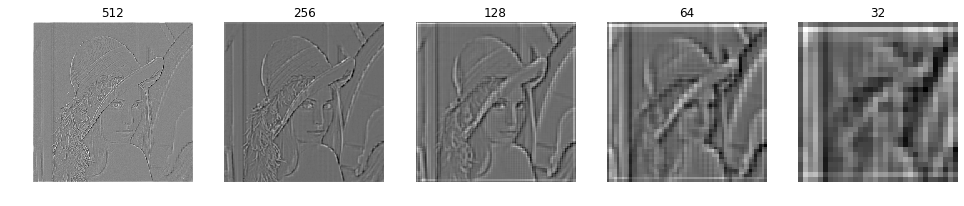

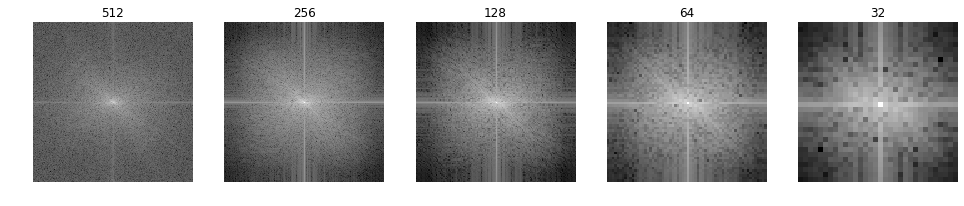

In [71]:
img = cv2.imread("datas/lena.jpg")
# img = cv2.imread("datas/makeup_before.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

gaussian_filter = get_gaussian_filter(kernel_size=(5,5), sigma=2)
pyramid_size = [512, 256, 128, 64, 32, 16]

gaussian_pyramid, laplacian_pyramid = image_pyramid(img_gray, gaussian_filter, pyramid_size)
num_imgs = len(pyramid_size)

# Plot Gaussian pyramid
plt.figure(figsize = (20,10))
for i, s in enumerate(pyramid_size):
    plt.subplot(1, num_imgs, i+1), plt.axis('off'), plt.title(s), plt.imshow(gaussian_pyramid[s], cmap='gray')
plt.show()

# Plot Laplacian pyramid
plt.figure(figsize = (20,10))
for i, s in enumerate(pyramid_size[:-1]):
    plt.subplot(1, num_imgs, i+1), plt.axis('off'), plt.title(s), plt.imshow(laplacian_pyramid[s], cmap='gray')
    
# Plot frequency imgs
plt.figure(figsize = (20,10))
for i, s in enumerate(pyramid_size[:-1]):
    img = gaussian_pyramid[s]
#     img = laplacian_pyramid[s]
    #img = nearest_interpolation(img, size=(512,512))
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    plt.subplot(1, num_imgs, i+1), plt.axis('off'), plt.title(s), plt.imshow(magnitude_spectrum, cmap='gray')
plt.show()